In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 6.7 MB/s 


In [ ]:
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

In [ ]:
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,auc,precision_recall_curve,roc_curve
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from stellargraph import IndexedArray

In [ ]:
import itertools
import matplotlib.pyplot as plt

In [ ]:
def read_para(path):
    df = pd.read_csv(path,sep='\t',header=None)
    dic = {}
    for i in range(df.shape[0]):
        hla = df[0].iloc[i]
        paratope = df[1].iloc[i]
        try:
            dic[hla] = paratope
        except KeyError:
            dic[hla] = []
            dic[hla].append(paratope)
    return dic

In [ ]:
def dict_inventory(inventory):
    dicA, dicB, dicC = {}, {}, {}
    dic = {'A': dicA, 'B': dicB, 'C': dicC}

    for hla in inventory:
        type_ = hla[4]  # A,B,C
        first2 = hla[6:8]  # 01
        last2 = hla[8:]  # 01
        try:
            dic[type_][first2].append(last2)
        except KeyError:
            dic[type_][first2] = []
            dic[type_][first2].append(last2)

    return dic

In [ ]:
def rescue_unknown_hla(hla, dic_inventory):
    type_ = hla[4]
    first2 = hla[6:8]
    last2 = hla[8:]
    big_category = dic_inventory[type_]
    #print(hla)
    if not big_category.get(first2) == None:
        small_category = big_category.get(first2)
        distance = [abs(int(last2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(first2) + str(optimal)
    else:
        small_category = list(big_category.keys())
        distance = [abs(int(first2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(optimal) + str(big_category[optimal][0])

In [ ]:
class Graph_Constructor():

    @staticmethod
    def combinator(pep,hla):
        source = ['p' + str(i+1) for i in range(len(pep))]
        target = ['h' + str(i+1) for i in range(len(hla))]
        return source,target

    @staticmethod
    def numerical(pep,hla,after_pca,embed=12):   # after_pca [21,12]
        pep = pep.replace('X','-').upper()
        hla = hla.replace('X','-').upper()
        feature_array_pep = np.empty([len(pep),embed])
        feature_array_hla = np.empty([len(hla),embed])
        amino = 'ARNDCQEGHILKMFPSTWYV-'
        for i in range(len(pep)):
            feature_array_pep[i,:] = after_pca[amino.index(pep[i]),:]
        for i in range(len(hla)):
            feature_array_hla[i,:] = after_pca[amino.index(hla[i]),:]
        feature_array = np.concatenate([feature_array_pep,feature_array_hla],axis=0)
        #print(feature_array_pep.shape,feature_array_hla.shape,feature_array.shape)
        return feature_array

    @staticmethod
    def unweight_edge(pep,hla,after_pca):
        source,target = Graph_Constructor.combinator(pep,hla)
        combine = list(itertools.product(source,target))
        weight = itertools.repeat(1,len(source)*len(target))
        edges = pd.DataFrame({'source':[item[0] for item in combine],'target':[item[1] for item in combine],'weight':weight})
        feature_array = Graph_Constructor.numerical(pep,hla,after_pca)
        try:nodes = IndexedArray(feature_array,index=source+target)
        except: print(pep,hla,feature_array.shape)
        graph = StellarGraph(nodes,edges,node_type_default='corner',edge_type_default='line')
        return graph

    @staticmethod
    def weight_anchor_edge(pep,hla,after_pca):
        source, target = Graph_Constructor.combinator(pep, hla)
        combine = list(itertools.product(source, target))
        weight = itertools.repeat(1, len(source) * len(target))
        edges = pd.DataFrame({'source': [item[0] for item in combine], 'target': [item[1] for item in combine], 'weight': weight})
        for i in range(edges.shape[0]):
            col1 = edges.iloc[i]['source']
            col2 = edges.iloc[i]['target']
            col3 = edges.iloc[i]['weight']
            if col1 == 'a2' or col1 == 'a9' or col1 ==  'a10':
                edges.iloc[i]['weight'] = 1.5
        feature_array = Graph_Constructor.numerical(pep, hla, after_pca)
        nodes = IndexedArray(feature_array, index=source + target)
        graph = StellarGraph(nodes, edges, node_type_default='corner', edge_type_default='line')
        return graph

    @staticmethod
    def intra_and_inter(pep,hla,after_pca):
        source, target = Graph_Constructor.combinator(pep, hla)
        combine = list(itertools.product(source, target))
        weight = itertools.repeat(2, len(source) * len(target))
        edges_inter = pd.DataFrame({'source': [item[0] for item in combine], 'target': [item[1] for item in combine], 'weight': weight})
        intra_pep = list(itertools.combinations(source,2))
        intra_hla = list(itertools.combinations(target,2))
        intra = intra_pep + intra_hla
        weight = itertools.repeat(1,len(intra))
        edges_intra = pd.DataFrame({'source':[item[0] for item in intra],'target':[item[1] for item in intra],'weight':weight})
        edges = pd.concat([edges_inter,edges_intra])
        edges = edges.set_index(pd.Index(np.arange(edges.shape[0])))
        feature_array = Graph_Constructor.numerical(pep, hla, after_pca)
        nodes = IndexedArray(feature_array, index=source + target)
        graph = StellarGraph(nodes, edges, node_type_default='corner', edge_type_default='line')
        return graph

    @staticmethod
    def entrance(df,after_pca,hla_dic,dic_inventory):
        graphs = []
        graph_labels = []
        for i in range(df.shape[0]):
            #print(i)
            pep = df['peptide'].iloc[i]
            try:
                hla = hla_dic[df['HLA'].iloc[i]]
            except KeyError:
                hla = hla_dic[rescue_unknown_hla(df['HLA'].iloc[i],dic_inventory)]
            label = df['immunogenicity'].iloc[i]
            #if label != 'Negative': label = 0
            #else: label = 1
            #graph = Graph_Constructor.unweight_edge(pep,hla,after_pca)
            #graph = Graph_Constructor.unweight_edge(pep,hla,after_pca)
            graph = Graph_Constructor.intra_and_inter(pep,hla,after_pca)
            graphs.append(graph)
            graph_labels.append(label)
        graph_labels = pd.Series(graph_labels)
        return graphs,graph_labels

In [ ]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=2, callbacks=[es],)
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]
    return history, test_acc

In [ ]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size)
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size)

    return train_gen, test_gen

In [ ]:
def draw_ROC(y_true,y_pred):

    fpr,tpr,_ = roc_curve(y_true,y_pred,pos_label=1)
    area_mine = auc(fpr,tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % area_mine)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def draw_PR(y_true,y_pred):
    precision,recall,_ = precision_recall_curve(y_true,y_pred,pos_label=1)
    area_PR = auc(recall,precision)
    baseline = np.sum(np.array(y_true) == 1) / len(y_true)

    plt.figure()
    lw = 2
    plt.plot(recall,precision, color='darkorange',
            lw=lw, label='PR curve (area = %0.2f)' % area_PR)
    plt.plot([0, 1], [baseline, baseline], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def draw_history(history):
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

In [ ]:
def hla_df_to_dic(hla):
    dic = {}
    for i in range(hla.shape[0]):
        col1 = hla['HLA'].iloc[i]  # HLA allele
        col2 = hla['pseudo'].iloc[i]  # pseudo sequence
        dic[col1] = col2
    return dic

In [ ]:
def retain_910(ori):
    cond = []
    for i in range(ori.shape[0]):
        peptide = ori['peptide'].iloc[i]
        if len(peptide) == 9 or len(peptide) == 10:
            cond.append(True)
        else:
            cond.append(False)
    data = ori.loc[cond]
    data = data.set_index(pd.Index(np.arange(data.shape[0])))
    return data

In [ ]:
    ori_train = pd.read_csv('remove0123_sample100.csv')
    hla = pd.read_csv('hla2paratopeTable_aligned.txt',sep='\t')
    after_pca = np.loadtxt('after_pca.txt')
    hla_dic = hla_df_to_dic(hla)
    inventory = list(hla_dic.keys())
    dic_inventory = dict_inventory(inventory)

    ori_train['immunogenicity'], ori_train['potential'] = ori_train['potential'], ori_train['immunogenicity']

In [ ]:
graphs, graph_labels = Graph_Constructor.entrance(ori_train, after_pca, hla_dic, dic_inventory)
generator = PaddedGraphGenerator(graphs=graphs)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(graphs, graph_labels, test_size = 0.33, random_state = 0)

In [ ]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

In [ ]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,8971.0,8971.0
mean,55.3,1500.3
std,0.4,24.6
min,55.0,1485.0
25%,55.0,1485.0
50%,55.0,1485.0
75%,56.0,1540.0
max,56.0,1540.0


In [ ]:
graph_labels.value_counts().to_frame()

,0
0.966471,2
0.347444,1
0.969029,1
0.969071,1
0.969070,1
...,...
0.254227,1
0.254350,1
0.254447,1
0.254539,1


In [ ]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [ ]:
ori_train1 = ori_train
ori_train1.loc[ori_train1["potential"] != "Negative", "potential"] = 'Positive'
ori_train1['potential'] = ori_train1['potential'].astype('category')
ori_train1['potential'] = pd.factorize(ori_train1['potential'])[0]
graph_labels = ori_train1['potential']

In [ ]:
graph_labels.value_counts().to_frame()

,potential
0,4912
1,4059


In [ ]:
generator = PaddedGraphGenerator(graphs=graphs)

#Link Prediction

In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [ ]:
graphs[0].info()

'StellarGraph: Undirected multigraph\n Nodes: 55, Edges: 1485\n\n Node types:\n  corner: [55]\n    Features: float64 vector, length 12\n    Edge types: corner-line->corner\n\n Edge types:\n    corner-line->corner: [1485]\n        Weights: range=[1, 2], mean=1.27879, std=0.448554\n        Features: none'

In [ ]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(graphs[0])

#Embeddings

In [ ]:
generator = sg.mapper.PaddedGraphGenerator(graphs)

In [ ]:
import stellargraph as sg
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow import keras

from IPython.display import display, HTML

In [ ]:
gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], ["relu", "relu"], generator, pool_all_layers=True
)

In [ ]:
inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()

vec_distance = tf.norm(out1 - out2, axis=1)

In [ ]:
pair_model = keras.Model(inp1 + inp2, vec_distance)
embedding_model = keras.Model(inp1, out1)

In [ ]:
def graph_distance(graph1, graph2):
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

In [ ]:
graph_idx = np.random.RandomState(0).randint(len(graphs), size=(100, 2))

In [ ]:
targets = [graph_distance(graphs[left], graphs[right]) for left, right in graph_idx]

In [ ]:
train_gen = generator.flow(graph_idx, batch_size=10, targets=targets)

In [ ]:
pair_model.compile(keras.optimizers.Adam(1e-2), loss="mse")

CPU times: user 55.6 s, sys: 2.11 s, total: 57.7 s
Wall time: 58.4 s


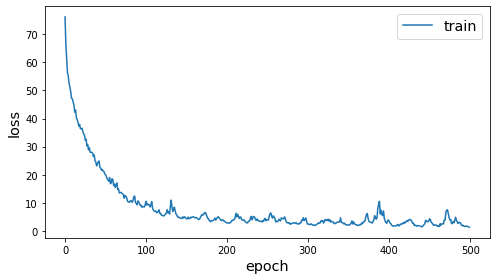

In [ ]:
%%time
history = pair_model.fit(train_gen, epochs=500, verbose=0)
sg.utils.plot_history(history)

In [ ]:
embeddings = embedding_model.predict(generator.flow(graphs))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

In [ ]:
train_labels, test_labels = model_selection.train_test_split(
    graph_labels, train_size=0.1, test_size=None, stratify=graph_labels
)

test_embeddings = embeddings[test_labels.index - 1]
train_embeddings = embeddings[train_labels.index - 1]

lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_labels)

y_pred = lr.predict(test_embeddings)
gcn_acc = (y_pred == test_labels).mean()
print(f"Test classification accuracy: {gcn_acc}")

Test classification accuracy: 0.6631161753777558


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
pd.crosstab(test_labels, y_pred, rownames=["true"], colnames=["predicted"])

predicted,0,1
true,,
0,3453,968
1,1752,1901


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
two_d = tsne.fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
type(graph_labels)

pandas.core.series.Series

In [ ]:
graph_labels

0       0
1       0
2       0
3       0
4       0
       ..
8966    1
8967    1
8968    1
8969    1
8970    1
Name: potential, Length: 8971, dtype: int64

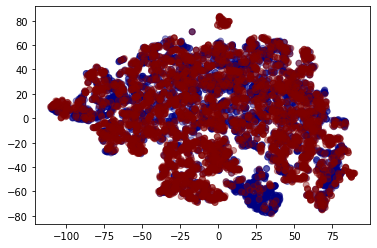

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(two_d[:, 0], two_d[:, 1], c=graph_labels, cmap="jet", alpha=0.4)